In [25]:
import GPy
GPy.__version__

'1.10.0'

As of Mon 12th of Oct running on devel branch of GPy 0.8.8

In [11]:
GPy.plotting.change_plotting_library('matplotlib')

# Gaussian process regression tutorial

### Nicolas Durrande 2013
#### with edits by James Hensman and Neil D. Lawrence

We will see in this tutorial the basics for building a 1 dimensional and a 2 dimensional Gaussian process regression model, also known as a kriging model.

We first import the libraries we will need:

In [12]:
import numpy as np

## 1-dimensional model

For this toy example, we assume we have the following inputs and outputs:

In [13]:
X = np.random.uniform(-3.,3.,(20,1))
Y = np.sin(X) + np.random.randn(20,1)*0.05

Note that the observations Y include some noise.

The first step is to define the covariance kernel we want to use for the model. We choose here a kernel based on Gaussian kernel (i.e. rbf or square exponential):

In [14]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

The parameter input_dim stands for the dimension of the input space. The parameters `variance` and `lengthscale` are optional, and default to 1. Many other kernels are implemented, type `GPy.kern.<tab>` to see a list

In [15]:
#type GPy.kern.<tab> here:
GPy.kern.BasisFuncKernel?

Init signature: GPy.kern.BasisFuncKernel(*args, **kw)
Docstring:     
Parameterized class

Say m is a handle to a parameterized class.

Printing parameters:

    - print m:           prints a nice summary over all parameters
    - print m.name:      prints details for param with name 'name'
    - print m[regexp]: prints details for all the parameters
                         which match (!) regexp
    - print m['']:       prints details for all parameters

    Fields:

        Name:       The name of the param, can be renamed!
        Value:      Shape or value, if one-valued
        Constrain:  constraint of the param, curly "{c}" brackets indicate
                    some parameters are constrained by c. See detailed print
                    to get exact constraints.
        Tied_to:    which paramter it is tied to.

Getting and setting parameters:

    Set all values in param to one:

        m.name.to.param = 1

Handling of constraining, fixing and tieing parameters:

    You can 

The inputs required for building the model are the observations and the kernel:

In [16]:
m = GPy.models.GPRegression(X,Y,kernel)

By default, some observation noise is added to the model. The functions `display` and `plot` give an insight of the model we have just built:

In [17]:
from IPython.display import display
display(m)

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


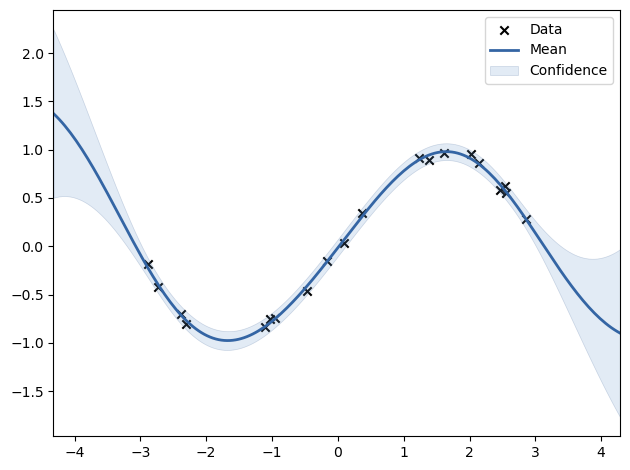

In [22]:
fig = m.plot()
# GPy.plotting.show(fig, filename='basic_gp_regression_notebook')

The above cell shows our GP regression model before optimization of the parameters. The shaded region corresponds to ~95% confidence intervals (ie +/- 2 standard deviation).

The default values of the kernel parameters may not be optimal for the current data (for example, the confidence intervals seems too wide on the previous figure). A common approach is to find the values of the parameters that maximize the likelihood of the data. It as easy as calling `m.optimize` in GPy:

In [19]:
m.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0004   8.260047e+05   3.128314e+10 
    00s02  0014  -1.647216e+01   3.705400e-01 
    00s02  0018  -1.673348e+01   3.169203e-02 
    00s03  0024  -1.675990e+01   8.222491e-09 
Runtime:     00s03
Optimization status: Converged



If we want to perform some restarts to try to improve the result of the optimization, we can use the `optimize_restarts` function. This selects random (drawn from $N(0,1)$) initializations for the parameter values, optimizes each, and sets the model to the best solution found.

In [20]:
m.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = -16.759896644815733
Optimization restart 2/10, f = -16.75989664488391
Optimization restart 3/10, f = -16.759896644884765
Optimization restart 4/10, f = -16.75989664488332
Optimization restart 5/10, f = -16.759896644856394
Optimization restart 6/10, f = -16.7598966448494
Optimization restart 7/10, f = -16.75989664488425
Optimization restart 8/10, f = -16.759896644883604
Optimization restart 9/10, f = -16.75989664488408
Optimization restart 10/10, f = -16.75989664488464


In this simple example, the objective function (usually!) has only one local minima, and each of the found solutions are the same. 

Once again, we can use `print(m)` and `m.plot()` to look at the resulting model resulting model. This time, the paraemters values have been optimized agains the log likelihood (aka the log marginal likelihood): the fit shoul dbe much better. 

GP_regression.,value,constraints,priors
rbf.variance,1.4221169706527457,+ve,
rbf.lengthscale,1.7643393737707136,+ve,
Gaussian_noise.variance,0.001569035636144651,+ve,


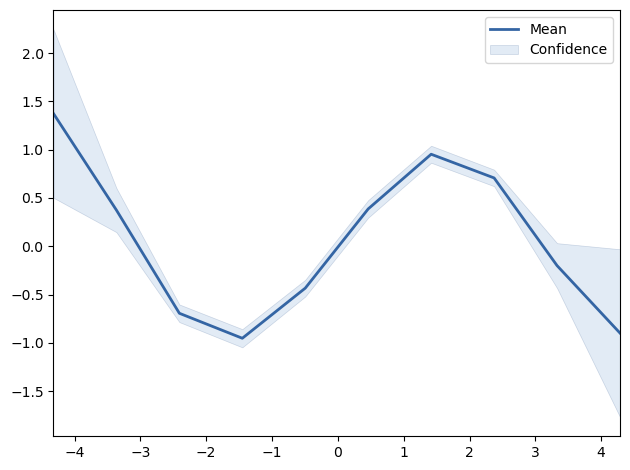

In [31]:
display(m)
fig = m.plot(resolution=10, plot_density=False, plot_data=False)
# GPy.plotting.show(fig, filename='basic_gp_regression_notebook_optimized')

### New plotting of GPy 0.9 and later
The new plotting allows you to plot the density of a GP object more fine grained by plotting more percentiles of the distribution color coded by their opacity

GP_regression.,value,constraints,priors
rbf.variance,1.4221169706527457,+ve,
rbf.lengthscale,1.7643393737707136,+ve,
Gaussian_noise.variance,0.001569035636144651,+ve,


TypeError: _process_unit_info() got an unexpected keyword argument 'xdata'

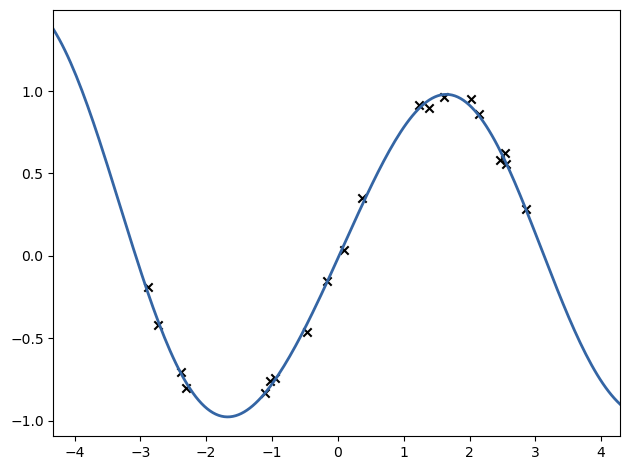

In [26]:
display(m)
fig = m.plot(plot_density=True)
GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

## 2-dimensional example

Here is a 2 dimensional example:

In [14]:
# sample inputs and outputs
X = np.random.uniform(-3.,3.,(50,2))
Y = np.sin(X[:,0:1]) * np.sin(X[:,1:2])+np.random.randn(50,1)*0.05

# define kernel
ker = GPy.kern.Matern52(2,ARD=True) + GPy.kern.White(2)

# create simple GP model
m = GPy.models.GPRegression(X,Y,ker)

# optimize and plot
m.optimize(messages=True,max_f_eval = 1000)
fig = m.plot()
display(GPy.plotting.show(fig, filename='basic_gp_regression_notebook_2d'))
display(m)

This is the format of your plot grid:
[ (1,1) x1,y1 ]



GP_regression.,value,constraints,priors
sum.Mat52.variance,0.361421808902,+ve,
sum.Mat52.lengthscale,"(2,)",+ve,
sum.white.variance,0.000644606566433,+ve,
Gaussian_noise.variance,0.000644606566433,+ve,


The flag `ARD=True` in the definition of the `Matern` kernel specifies that we want one lengthscale parameter per dimension (ie the GP is not isotropic). Note that for 2-d plotting, only the mean is shown. 

## Plotting slices
To see the uncertaintly associated with the above predictions, we can plot slices through the surface. this is done by passing the optional `fixed_inputs` argument to the plot function. `fixed_inputs` is a list of tuples containing which of the inputs to fix, and to which value.

To get horixontal slices of the above GP, we'll fix second (index 1) input to -1, 0, and 1.5:

In [15]:
slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1, 
                        shared_xaxes=True,
                        subplot_titles=('slice at -1', 
                                        'slice at 0', 
                                        'slice at 1.5', 
                                        )
                            )
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(1,y)], row=(i+1), plot_data=False)
GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]



A few things to note:
 * we've also passed the optional `ax` argument, to mnake the GP plot on a particular subplot
 * the data look strange here: we're seeing slices of the GP, but all the data are displayed, even though they might not be close to the current slice.

To get vertical slices, we simply fixed the other input. We'll turn the display of data off also:

In [16]:
slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1, 
                        shared_xaxes=True,
                        subplot_titles=('slice at -1', 
                                        'slice at 0', 
                                        'slice at 1.5', 
                                        )
                            )
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(0,y)], row=(i+1), plot_data=False)
GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing_vertical')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]



You can find a host of other plotting options in the `m.plot` docstring. `Type m.plot?<enter>` to see. 